In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm_notebook as tqdm
import warnings

%pylab inline

tfd = tfp.distributions
tfpk = tfp.positive_semidefinite_kernels

np.random.seed(42)

Populating the interactive namespace from numpy and matplotlib


In [2]:
from IPython.display import display, HTML
def html_header(astr,level=1):
    return display(HTML('<h{}>{}</h{}>'.format(level,astr,level))) 

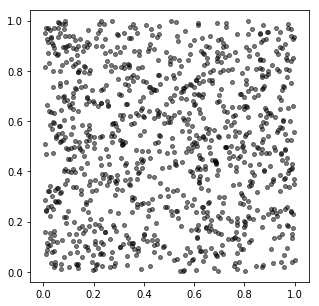

In [3]:
num_beads = 1000
spatial_dims = 2
X_ = np.random.uniform(0., 1., [num_beads, spatial_dims])

plt.figure(figsize=(5, 5))
plt.scatter(X_[:, 0], X_[:, 1], 
            s=16, alpha=0.5, c='black')
plt.axis('equal')
plt.show()

In [5]:
num_genes = 20
num_clusters = 4

In [12]:
W_bool_ = np.array([[1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1],
                  [1, 1, 0, 0],
                  [1, 0, 1, 0],
                  [1, 0, 0, 1],
                  [0, 1, 1, 0],
                  [0, 1, 0, 1],
                  [0, 0, 1, 1],
                  [0, 1, 1, 1],
                  [1, 0, 1, 1],
                  [1, 1, 0, 1],
                  [1, 1, 1, 0],
                  [1, 1, 1, 1],
                  [1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1],
                  [1, 0, 0, 0]])

amp_vec_ = np.array([25, 20, 13, 30, 7, 15, 4, 6, 4, 15, 3, 9, 2, 2, 0.5, 3, 4, 5, 3, 2])

In [13]:
W_ = np.diag(amp_vec_) @ W_bool_

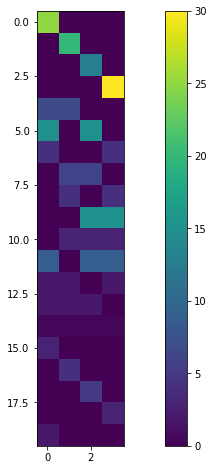

In [14]:
plt.figure(figsize=(15, 8))
plt.imshow(W_, interpolation='none')
plt.colorbar()
plt.show()

# Stripes

In [15]:
def get_stripe_pattern(coord_vec):
    pos_x = coord_vec[0]
    if 0 <= pos_x < 0.25:
        return np.array([1, 0, 0, 0])
    elif pos_x < 0.5:
        return np.array([0, 1, 0, 0])
    elif pos_x < 0.75:
        return np.array([0, 0, 1, 0])
    else:
        return np.array([0, 0, 0, 1])

In [16]:
fs_stripe_ = np.array([get_stripe_pattern(x) for x in X_]).T

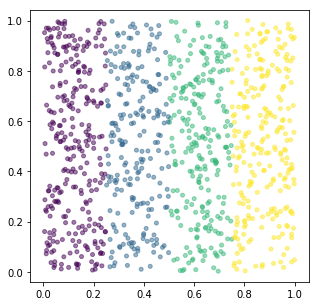

In [17]:
plt.figure(figsize=(5, 5))
plt.scatter(X_[:, 0], X_[:, 1], 
            s=16, alpha=0.5, 
            c=np.argmax(fs_stripe_, axis=0))
plt.axis('equal')
plt.show()

In [18]:
pois_rates_stripe_ = W_ @ fs_stripe_
gene_counts_stripe_ = tfd.Poisson(pois_rates_stripe_).sample().numpy()

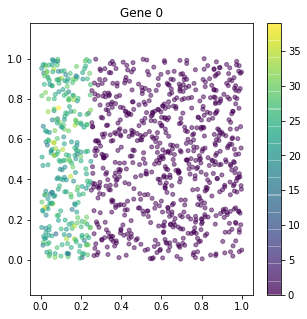

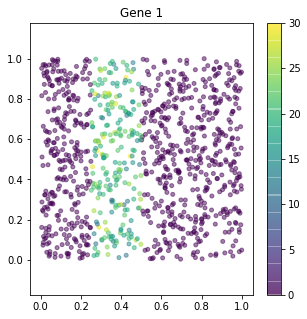

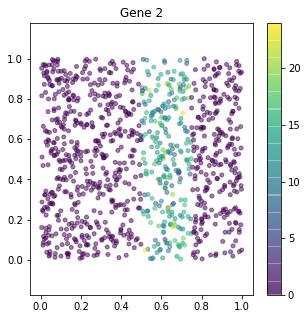

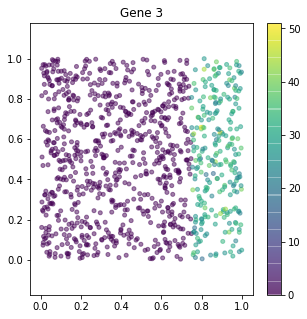

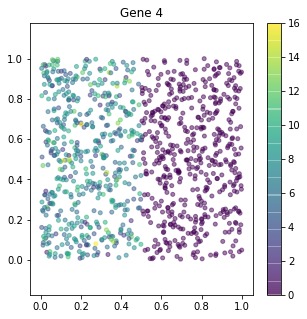

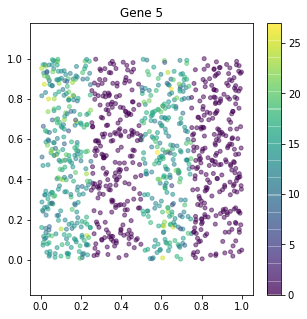

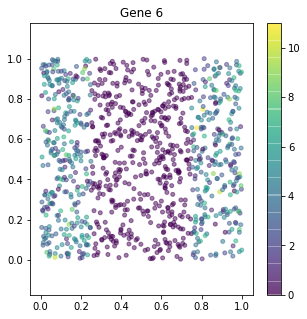

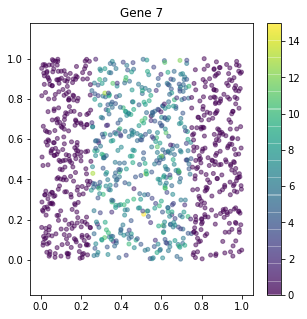

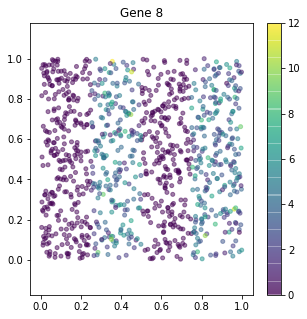

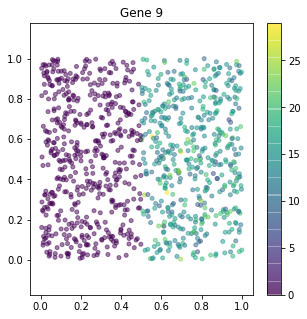

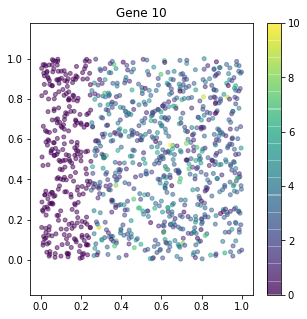

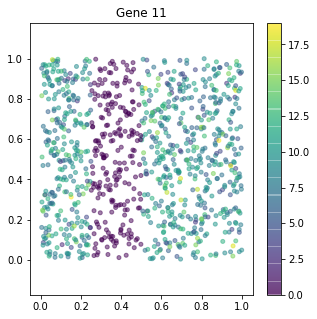

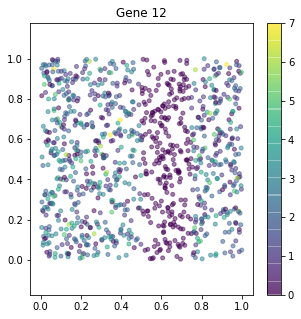

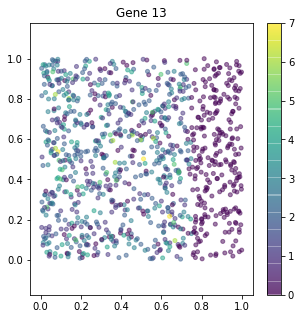

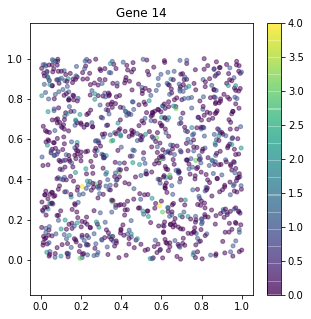

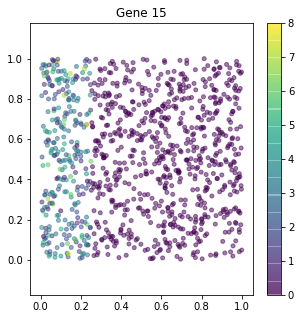

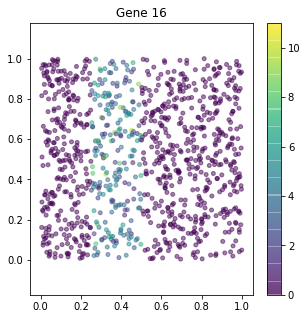

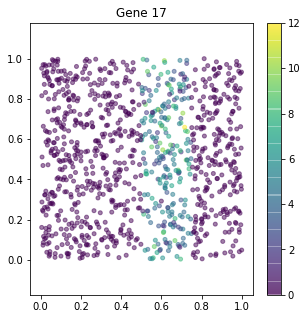

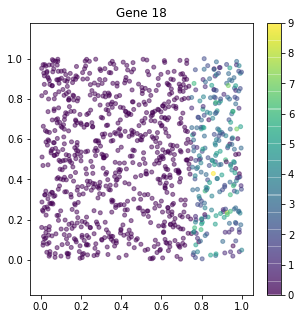

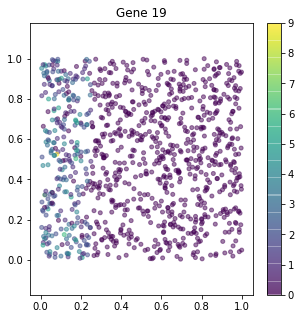

In [19]:
for gene in range(num_genes):
    plt.figure(figsize=(5, 5))
    plt.scatter(X_[:, 0], X_[:, 1], 
            s=16, alpha=0.5, 
            c=gene_counts_stripe_[gene, :])
    plt.title('Gene {}'.format(gene))
    plt.axis('equal')
    plt.colorbar()
    plt.show()

# Darts

In [20]:
def get_darts_pattern(coord_vec):
    rad = np.linalg.norm(coord_vec - np.array([0.5, 0.5]))
    if rad < 0.20:
        return np.array([1, 0, 0, 0])
    elif rad < 0.35:
        return np.array([0, 1, 0, 0])
    elif rad < 0.45:
        return np.array([0, 0, 1, 0])
    else:
        return np.array([0, 0, 0, 1])

In [21]:
fs_darts_ = np.array([get_darts_pattern(x) for x in X_]).T

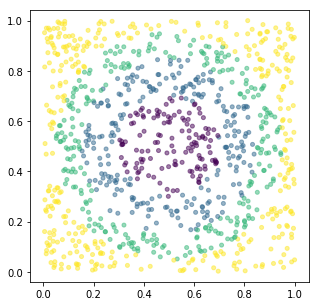

In [22]:
plt.figure(figsize=(5, 5))
plt.scatter(X_[:, 0], X_[:, 1], 
            s=16, alpha=0.5, 
            c=np.argmax(fs_darts_, axis=0))
plt.axis('equal')
plt.show()

In [23]:
pois_rates_darts_ = W_ @ fs_darts_
gene_counts_darts_ = tfd.Poisson(pois_rates_darts_).sample().numpy()

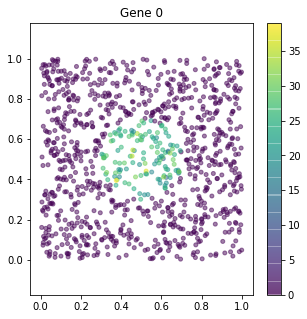

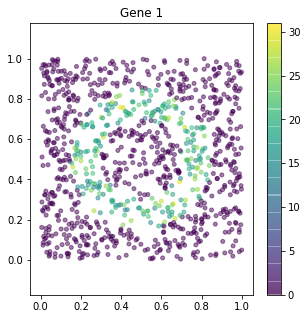

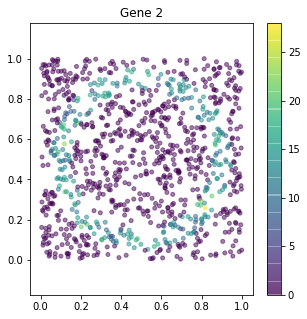

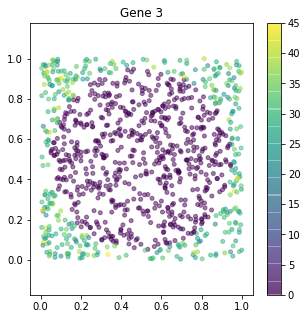

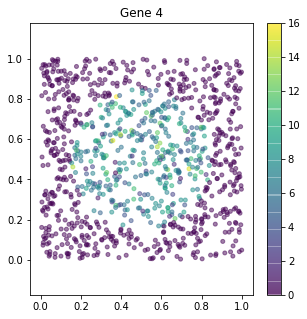

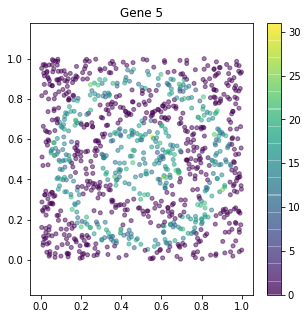

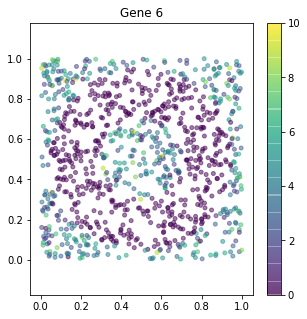

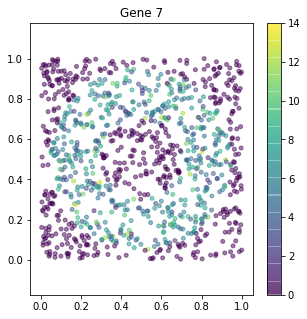

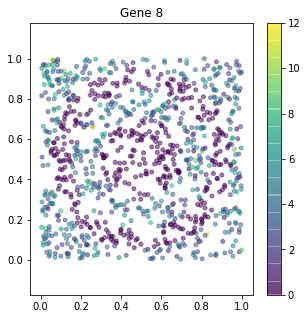

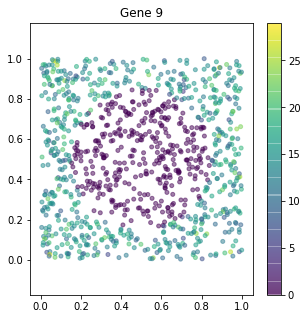

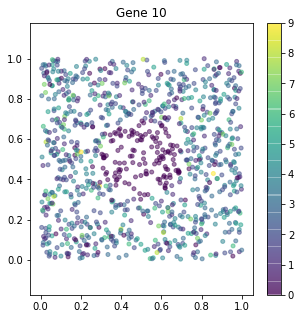

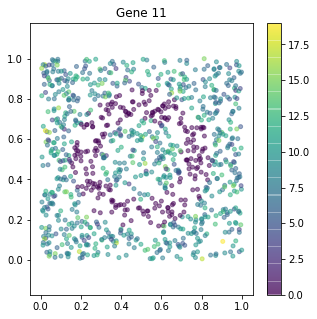

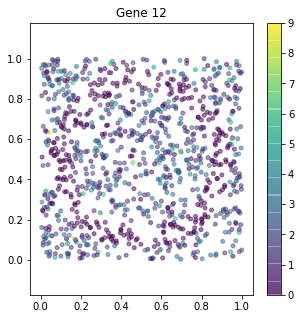

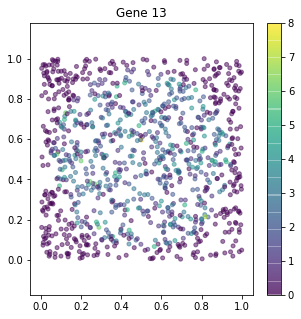

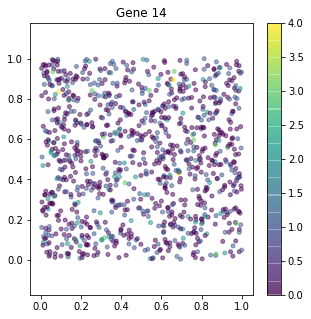

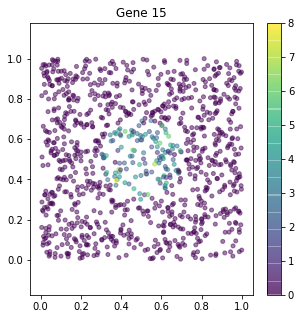

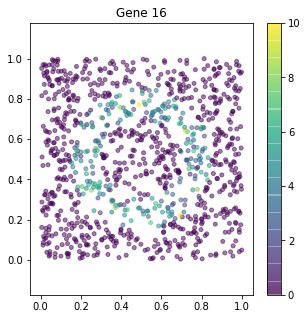

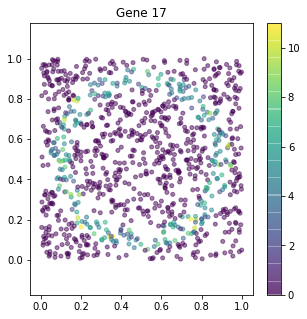

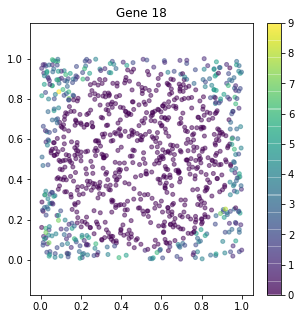

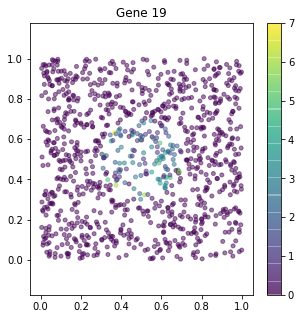

In [24]:
for gene in range(num_genes):
    plt.figure(figsize=(5, 5))
    plt.scatter(X_[:, 0], X_[:, 1], 
            s=16, alpha=0.5, 
            c=gene_counts_darts_[gene, :])
    plt.title('Gene {}'.format(gene))
    plt.axis('equal')
    plt.colorbar()
    plt.show()

# Slideseq synthetic (puck 180819_12)

* Cerebellum HVGs

In [4]:
vargenes_path = "data/vargenes.csv"
vargenes = pd.read_csv(vargenes_path)['x']

In [5]:
puck_number = '180819_12'
puck_data_path = 'data/seqpuck{}'.format(puck_number)

figures_path = '{}/figures/'.format(puck_number)
if not os.path.exists(figures_path):
    os.makedirs(figures_path)
    
def save_result(name):
    plt.savefig("{}/{}.png".format(figures_path, name),
                bbox_inches='tight', 
               transparent=False,
                dpi=300)
    plt.savefig("{}/{}.svg".format(figures_path, name),
                bbox_inches='tight', 
               transparent=True)

In [6]:
counts = pd.read_csv("{}/counts_gr0_seqpuck{}.csv".format(puck_data_path, puck_number))
print(counts.shape)
coords = pd.read_csv("{}/sample_info_gr0_seqpuck{}.csv".format(puck_data_path, puck_number))
print(coords.shape)
merged_df = counts.merge(coords, left_on = 'barcode', right_on = 'barcode')
print(merged_df.shape)

gene_intersection = list(set(vargenes) & set(counts.columns[1:]))
gnames = gene_intersection
X = merged_df[['x', 'y']].values.astype(float)
Y = merged_df[gnames].values.astype(float)

(46376, 19245)
(46376, 4)
(46376, 19248)


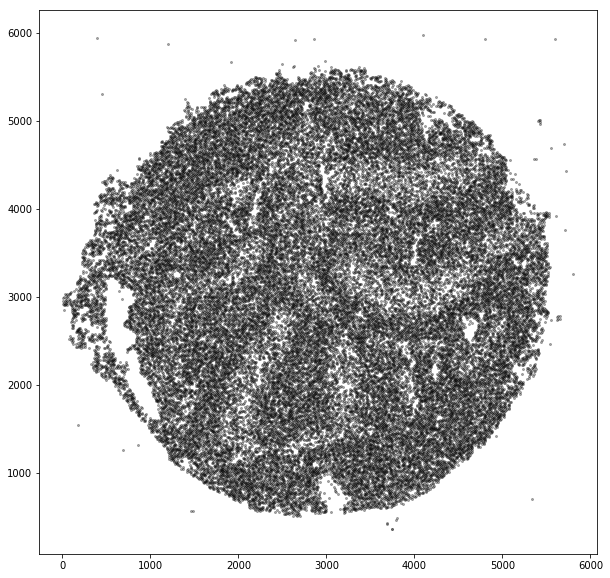

In [9]:
plt.figure(figsize=(10, 10))
plt.scatter(merged_df['x'], merged_df['y'], 
                s=4, alpha=0.3, c='black')
plt.axis('equal')
plt.show()

## kmeans

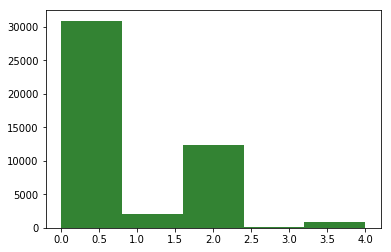

In [59]:
Ys = StandardScaler()
data = Ys.fit_transform(Y)

n_samples, n_features = data.shape
###############
n_clusters = 5
n_pcs = 2
###############

reduced_data = PCA(n_components=n_pcs).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
kmeans.fit(reduced_data)

plt.hist(kmeans.labels_, bins=n_clusters, alpha=0.8, color='darkgreen')
plt.show()

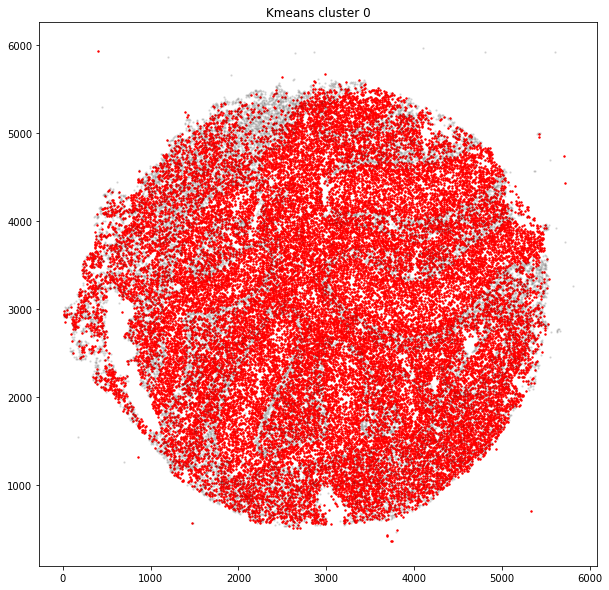

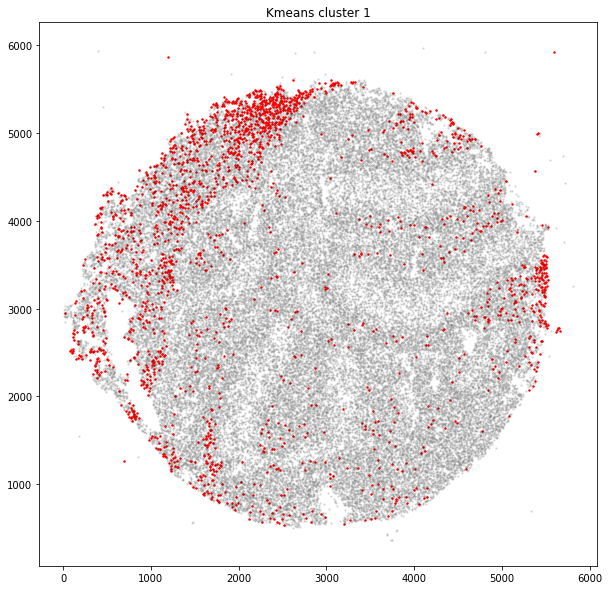

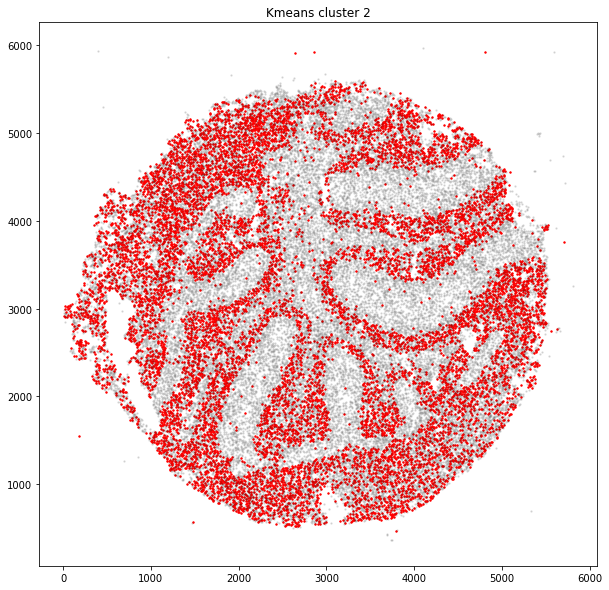

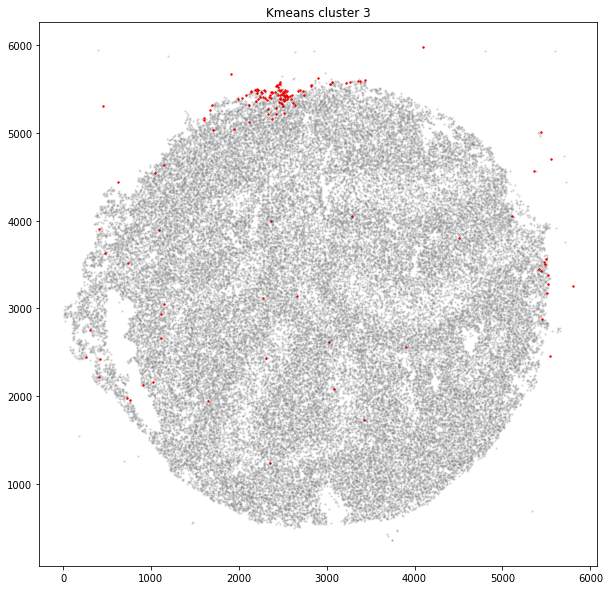

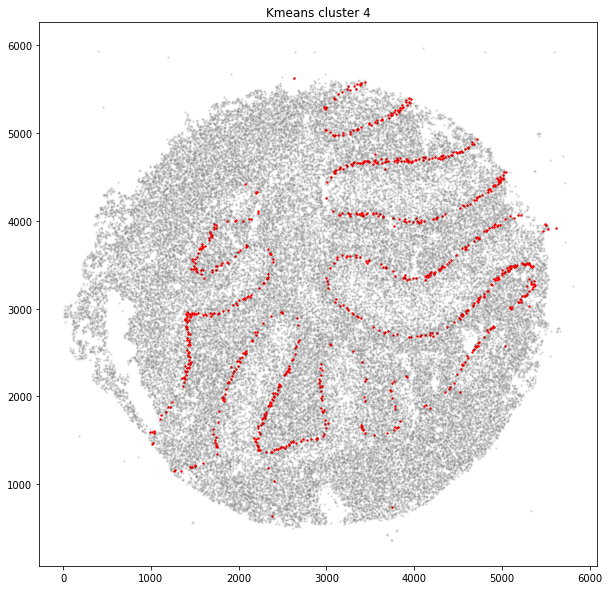

In [60]:
beads_kmeans_labels_df = coords.copy()
beads_kmeans_labels_df['label'] = kmeans.labels_

for cl in range(n_clusters):
    sub_df_yes = beads_kmeans_labels_df[beads_kmeans_labels_df['label']==cl]
    sub_df_no = beads_kmeans_labels_df[beads_kmeans_labels_df['label']!=cl]
    plt.figure(figsize=(10, 10))
    plt.scatter(sub_df_yes['x'], sub_df_yes['y'], 
                s=2, alpha=1, c='red')
    plt.scatter(sub_df_no['x'], sub_df_no['y'], 
                s=2, alpha=0.1, c='black')
    plt.axis('equal')
    plt.title('Kmeans cluster {}'.format(cl))
    #save_result(gene)

plt.show()

In [81]:
coords_query = coords.query('4200<x<5000').query('3000<y<3600')
print(coords_query.shape)
coords_query.head(3)

(1012, 4)


barcode            x            y  total_counts
9   AGCCGTTAGGGGGN  4790.089820  3593.916168          21.0
15  CACTTCTATTTTTT  4378.547619  3410.468254         127.0
26  AAGGGGGATTTTTN  4803.428571  3055.871429          38.0

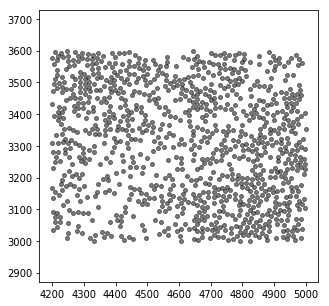

In [82]:
plt.figure(figsize=(5, 5))
plt.scatter(coords_query['x'], coords_query['y'], 
                s=16, alpha=0.5, c='black')
plt.axis('equal')
plt.show()

In [83]:
query_indx = beads_kmeans_labels_df['barcode'].isin(coords_query['barcode'])
kmeans_labels_query_df = beads_kmeans_labels_df[query_indx]
kmeans_labels_query_df['label'][kmeans_labels_query_df['label']==4]=3

(1012, 5)

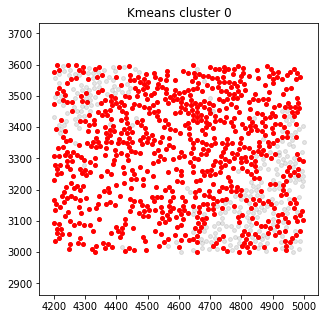

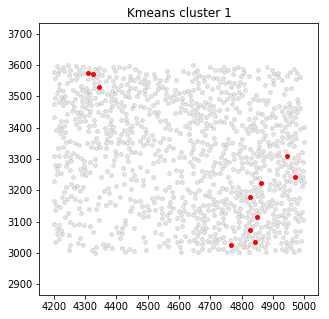

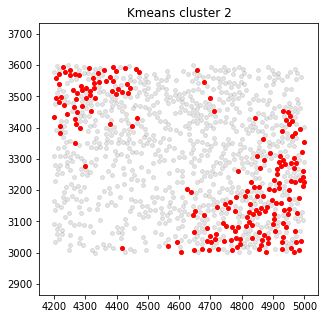

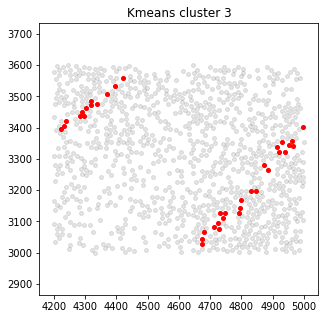

In [87]:
for cl in range(4):
    sub_df_yes = kmeans_labels_query_df[kmeans_labels_query_df['label']==cl]
    sub_df_no = kmeans_labels_query_df[kmeans_labels_query_df['label']!=cl]
    plt.figure(figsize=(5, 5))
    plt.scatter(sub_df_yes['x'], sub_df_yes['y'], 
                s=16, alpha=1, c='red')
    plt.scatter(sub_df_no['x'], sub_df_no['y'], 
                s=16, alpha=0.1, c='black')
    plt.axis('equal')
    plt.title('Kmeans cluster {}'.format(cl))
    #save_result(gene)

plt.show()

In [209]:
num_clusters = len(kmeans_labels_query_df['label'].unique())

def lookup_fn(coord_vec):
    sub_df = kmeans_labels_query_df.query('x=={}'.format(coord_vec[0]))
    sub_df = sub_df.query('y=={}'.format(coord_vec[1]))
    if len(sub_df)==0:
        raise ValueError('{} is not in our x,y beads!'.format(x_vec))
    else:
        f_vec = np.zeros(num_clusters)
        label = sub_df['label'].tolist()[0]
        f_vec[label] = 1
        return f_vec

In [210]:
X_puck_ = kmeans_labels_query_df[['x','y']].values
labels = kmeans_labels_query_df['label'].values
fs_puck_ = np.zeros((num_clusters, X_puck_.shape[0]))
for indx, i in enumerate(labels):
    fs_puck_[i, indx]=1

In [212]:
pois_rates_puck_ = W_ @ fs_puck_
gene_counts_puck_ = tfd.Poisson(pois_rates_puck_).sample().numpy()

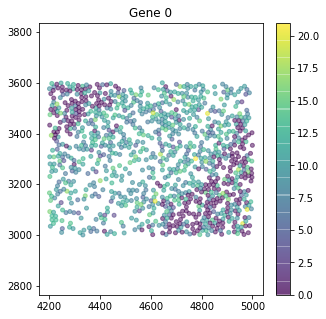

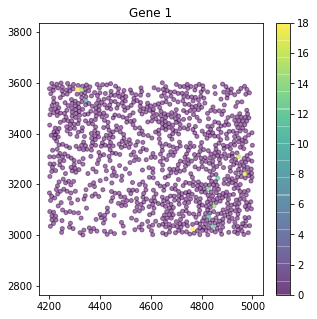

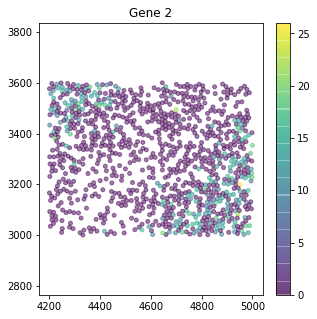

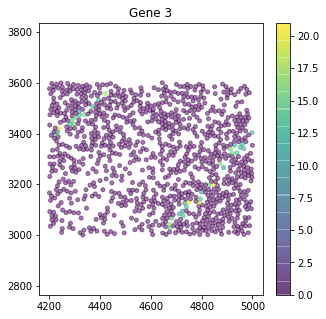

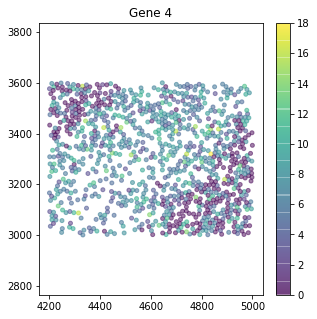

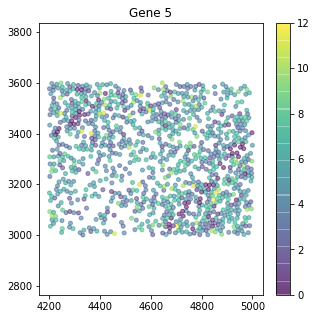

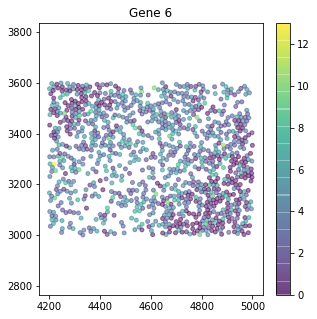

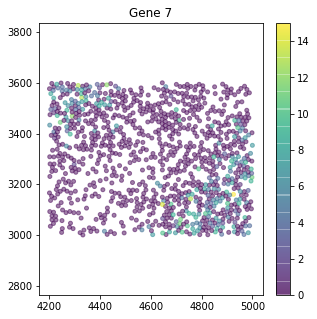

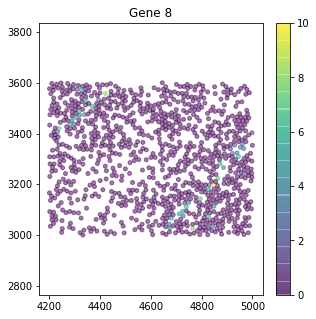

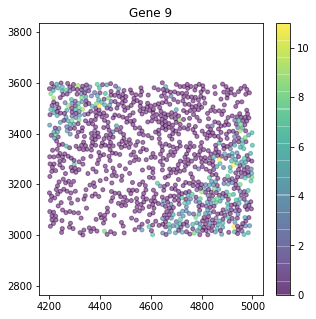

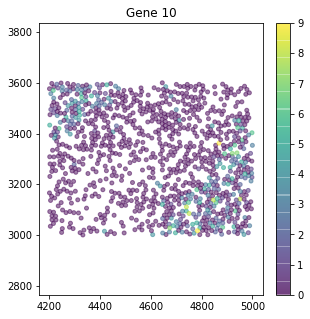

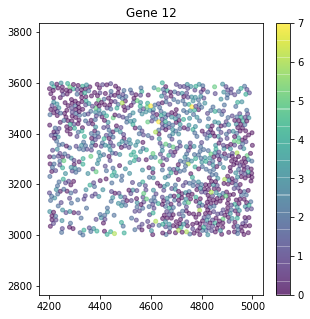

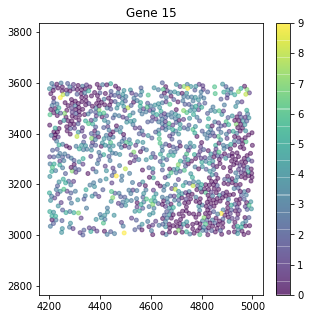

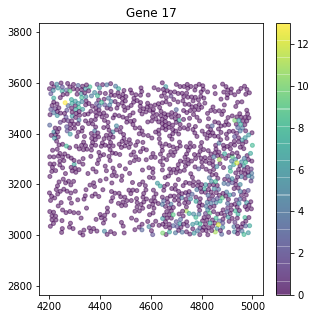

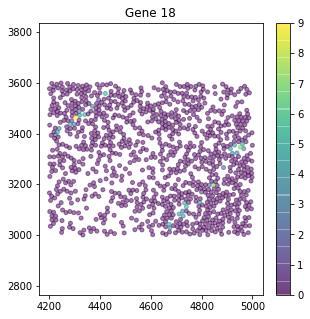

In [213]:
for gene in range(num_genes):
    plt.figure(figsize=(5, 5))
    plt.scatter(X_puck_[:, 0], X_puck_[:, 1], 
            s=16, alpha=0.5, 
            c=gene_counts_puck_[gene, :])
    plt.title('Gene {}'.format(gene))
    plt.axis('equal')
    plt.colorbar()
    plt.show()

## TODO: Provide interesting genes ~ 20: some def important, some questionable